# Adaptable irrigation strategies 
## soil moisture targets

Previous work has examined the benifits of choosing the optimal irrigation stratgy for farm profits and water use efficiency.

Though as the season unfolds, farmers may want to adjust their irrigation strategy based on the climate conditions so far and their expectation of the weather for the rest of the season.


In [1]:
# !pip install aquacrop

In [1]:
from aquacrop.classes import *
from aquacrop.core import *
from aquacrop.lars import *

from scipy.optimize import differential_evolution
import numpy as np
from functools import partial
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from aquacropgym.utils import calc_eto_faopm

#CP  Lat.(deg)= 40.40  Long.(deg)=101.73  Elev.(m)=1072.
gendf=calc_eto_faopm('data/CPWG.dat',2018,40.4,1072,True,["simyear","jday","minTemp","maxTemp","precip","rad"])


In [4]:
class FixedThresholdAgent():
    def __init__(self,smts):
        self.smts=smts # gievn as fraction

    
    def compute_action(self,obs):
        "default observation set"

        return (self.smts*2)-1

        gs = int(obs[7])-1
        dep = obs[2]

        if gs<0 or gs>3:
            action=0
        else:
            if 1-dep< (self.smts[gs]):
                action = 1
            else:
                action=0

        return action


In [5]:
from aquacropgym.envs import CropEnv, nebraska_maize_config
from aquacropgym.utils import evaluate_agent


In [14]:
# proftrain=[]
# proftest=[]
# timesteps=[]
# global_best=np.ones(1000)*-1000



#     global_best[i]=max(global_best[i],cumulative_reward)

#     print(f'Train:{round(train_reward/70,3)}')
#     print(f'Test:{round(test_reward/30,3)}')
#     print(f'Global_Train:{round(global_best[:70].mean(),3)}')
#     print(f'Global_Test:{round(global_best[70:100].mean(),3)}')
    
#     proftrain.append(train_reward/70)
#     proftest.append(test_reward/30)
#     timesteps.append(ts)
        


In [6]:
test_env_config=nebraska_maize_config.copy()

test_env_config['gendf']=gendf
test_env_config['evaluation_run']=True
test_env_config['normalize_obs']=False
test_env_config['action_set']='smt4'
test_env_config['observation_set']='default'

In [7]:
evaluate_agent(FixedThresholdAgent(np.array([0.58709859, 0.66129679, 0.34608978, 0.10645481])),CropEnv,test_env_config)

(554.6136831075852, 556.6010960450984)

In [23]:
def evaluate(smt,year1,year2,simyear,eval=False,):
    
    wdf = gendf[gendf.simyear==simyear].drop('simyear',axis=1)


    smt=smt.flatten()

    model = AquaCropModel(f'{year1}/05/01',f'{year2}/12/31',wdf,
            Soil=SoilClass('SiltClayLoam'),Crop=CropClass('Maize',PlantingDate='05/01'),
            InitWC=InitWCClass(wc_type='Pct',value=[70]),IrrMngt=IrrMngtClass(5))

    model.initialize()
#     model.weather[:,2]=0
    # model.weather[:,3]=3.5

    while not model.ClockStruct.ModelTermination:
        if model.InitCond.TAW>0:
            dep = model.InitCond.Depletion/model.InitCond.TAW
        else:
            dep=0

        gs = int(model.InitCond.GrowthStage)-1
        # gs = int(model.InitCond.DAP/8)
        if gs<0 or gs>3:
            depth=0
        else:
            if 1-dep< smt[gs]:
                depth = min(dep*model.InitCond.TAW,model.IrrMngt.MaxIrr)
            else:
                depth=0

        model.ParamStruct.IrrMngt.depth = depth
        model.step()


        if model.ClockStruct.ModelTermination:
            break

    fin = model.Outputs.Final
    if eval:
        return model.Outputs
    else:
        prof = (fin['Yield (tonne/ha)'].mean()*180 - fin['Seasonal irrigation (mm)'].mean()*1 -1728)
        # if t%50==0:
        #     train_prof.append(prof)
        #print(t,prof)
        return -prof

In [24]:
def eval_all(smt,year1,year2,eval=False,num=70,start=0):
    p=0
    for y in range(start+1,start+num+1):
        p += evaluate(smt,year1,year2,y,eval=False,)
    
    
    return p/num

In [25]:
eval_all(np.ones(4)*0.9,2018,2018,)

-136.71258654564437

In [22]:
# potential=[]
# for i in range(30):
#     func =partial(evaluate,year1=2018,year2=2018,simyear=i+71,eval=False)
#     max_bound = np.ones(4)
#     min_bound = np.zeros(4)
#     bounds = [(min_bound[i], max_bound[i]) for i in range(4)]

#     res = differential_evolution(func,bounds=bounds,disp=True,workers=8,seed=42)
#     potential.append(res)

In [10]:
np.mean([p.fun for p in potential])

-599.1008650497271

In [28]:
# evaluate(np.ones(4)*0.9,1982,2018)

In [27]:
# for y in range(1979,2002):
#     print(evaluate(res.x,y,y))

Get soil moisture target that maxises profit over 30 years

In [26]:
func =partial(eval_all,year1=2018,year2=2018)

max_bound = np.ones(4)
min_bound = np.zeros(4)
bounds = [(min_bound[i], max_bound[i]) for i in range(4)]

res = differential_evolution(func,bounds=bounds,disp=True,workers=8,seed=42)

/home/mbyx3tk2/anaconda3/envs/paper2ray/lib/python3.7/site-packages/scipy/optimize/_differentialevolution.py:497: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  " updating='deferred'", UserWarning)


differential_evolution step 1: f(x)= -497.295
differential_evolution step 2: f(x)= -522.238
differential_evolution step 3: f(x)= -538.767
differential_evolution step 4: f(x)= -539.629
differential_evolution step 5: f(x)= -539.629
differential_evolution step 6: f(x)= -551.711
differential_evolution step 7: f(x)= -551.711
differential_evolution step 8: f(x)= -554.602
differential_evolution step 9: f(x)= -554.602
differential_evolution step 10: f(x)= -554.602
differential_evolution step 11: f(x)= -554.602
differential_evolution step 12: f(x)= -554.614
differential_evolution step 13: f(x)= -554.614


In [27]:
res

     fun: -554.6139134781413
 message: 'Optimization terminated successfully.'
    nfev: 845
     nit: 13
 success: True
       x: array([0.58709859, 0.66129679, 0.34608978, 0.10645481])

In [ ]:
av_smt = np.array([ 7.11371398, 46.83206155, 58.97026889, 31.75414135])/100

In [28]:
eval_all( res.x,2018,2018,num=30,start=70)

-556.6010271619306

In [11]:
res_list_wg=[]
for i in range(70,100):
    r = eval_all(res.x,2018,2018,num=1,start=i)
    print(r)
    res_list_wg.append(r)
    

-459.2759210158474
-401.99739373625107
-558.759183084162
-605.5850589896859
-577.2292200749644
-510.34682700585245
-542.2888396823973
-505.02041843602274
-456.77792685616487
-577.1707363433175
-636.1506409852109
-602.7711795058754
-777.8043103476066
-593.4408042660802
-512.108795784508
-696.1894640513378
-693.3016136600722
-651.1922618199392
-589.9675228336187
-344.5932488765634
-565.0140272786962
-683.1480084673408
-629.5545331776584
-584.482236306314
-737.3763554467323
-432.50206221854796
-571.9076991529073
-606.4074698240274
-515.2351520925422
-464.21103831607843


In [12]:
np.mean(res_list_wg)

-569.3936649878775

In [14]:
pd.DataFrame(res_list_wg).to_csv('adapt_wg/smt_fixed_results.csv',index=None)

In [ ]:
func =partial(evaluate,year1=2012,year2=2018)

max_bound = np.ones(3)
min_bound = np.zeros(3)
bounds = [(min_bound[i], max_bound[i]) for i in range(3)]

res1 = differential_evolution(func,bounds=bounds,disp=True,workers=2,seed=74)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/_differentialevolution.py:494: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  " updating='deferred'", UserWarning)


differential_evolution step 1: f(x)= -248.331
differential_evolution step 2: f(x)= -248.653
differential_evolution step 3: f(x)= -250.679
differential_evolution step 4: f(x)= -250.679
differential_evolution step 5: f(x)= -250.679
differential_evolution step 6: f(x)= -251.66
differential_evolution step 7: f(x)= -251.691
differential_evolution step 8: f(x)= -254.366
differential_evolution step 9: f(x)= -256.087
differential_evolution step 10: f(x)= -256.087
differential_evolution step 11: f(x)= -256.087
differential_evolution step 12: f(x)= -259.104
differential_evolution step 13: f(x)= -259.104
differential_evolution step 14: f(x)= -259.104
differential_evolution step 15: f(x)= -259.104


In [ ]:
import pandas as pd
df=pd.DataFrame([smt_results,prof_results]).T
df.to_csv('smt_overfit_result.csv')

In [ ]:
df[1].mean()

183.65716435997643

In [ ]:
df[0].values

array([array([ 8.07309422, 56.03787163, 32.83445678,  8.48438302]),
       array([37.34019905, 65.27735051, 35.28847455, 15.38780506]),
       array([51.7317701 , 46.89369783, 35.92089835, 10.02645922]),
       array([59.39765424, 64.35201032, 35.78182169,  9.69235052]),
       array([25.40832237, 60.29783402, 29.23744136, 19.09748257]),
       array([31.48267343, 34.84145718, 32.10836344,  1.51209764]),
       array([30.84500151, 60.22684658, 34.2876768 , 10.44790696]),
       array([49.44797449, 46.13155435, 32.79968056,  7.876749  ]),
       array([39.22932252, 47.23288211, 37.30616176,  0.76461161]),
       array([ 4.47272216, 78.25687989, 32.0500628 ,  3.2691595 ]),
       array([44.69912905, 52.92413149,  5.90331117,  7.02456429]),
       array([45.97089299,  0.47097631, 32.95224154,  7.93646756]),
       array([55.85861262, 45.99901067, 37.43145377, 10.67505017]),
       array([42.53750533, 50.9547912 , 31.99803026,  1.15970064]),
       array([44.34282466, 25.42241742, 22.75187

56.03787163

In [ ]:
res.fun

-322.51599464072933

In [ ]:
res

     fun: -147.35177146032174
 message: 'Optimization terminated successfully.'
    nfev: 2165
     nit: 35
 success: True
       x: array([0.07113714, 0.46832062, 0.58970269, 0.31754141])

In [ ]:
df = pd.DataFrame(np.array([ 7.11371398, 46.83206155, 58.97026889, 31.75414135]))
df.to_csv('mean_best_smt.csv')

In [ ]:
tra = evaluate(res.x,1982,2011,True)

mean_train_prof=(tra.Final['Yield (tonne/ha)']*180 - tra.Final['Seasonal irrigation (mm)']*1  -1728).values

In [ ]:
mean_train_df = pd.DataFrame(mean_train_prof,columns=['mean_profit'])
mean_train_df['year']= np.arange(1982,2012)
mean_train_df['train_test'] = 'train'

In [ ]:
t = evaluate(res.x,2012,2018,True);t

In [ ]:
mean_test_prof = (t.Final['Yield (tonne/ha)']*180 - t.Final['Seasonal irrigation (mm)']*1  -1728).values
mean_test_df = pd.DataFrame(mean_test_prof,columns=['mean_profit'])
mean_test_df['year']= np.arange(2012,2019)
mean_test_df['train_test'] = 'test'

In [ ]:
mean_df = pd.concat([mean_train_df,mean_test_df])

In [ ]:
mean_df['smt1'] = res.x[0]*100
mean_df['smt2'] = res.x[1]*100
mean_df['smt3'] = res.x[2]*100

In [ ]:
mean_df.head()

,mean_profit,year,train_test,smt1,smt2,smt3
0,529.639603,1982,train,47.595163,61.197686,36.150318
1,167.107559,1983,train,47.595163,61.197686,36.150318
2,181.258515,1984,train,47.595163,61.197686,36.150318
3,283.784067,1985,train,47.595163,61.197686,36.150318
4,425.477395,1986,train,47.595163,61.197686,36.150318


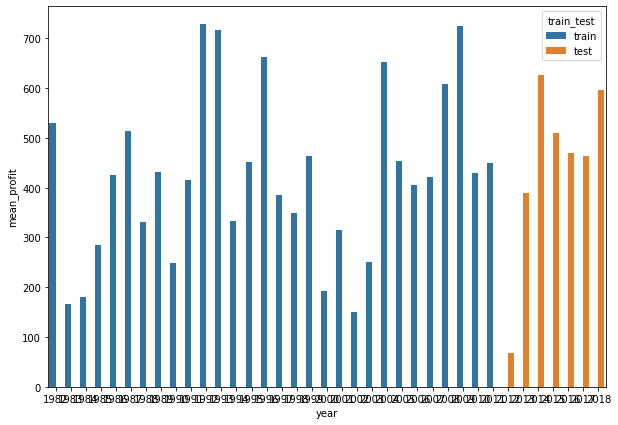

In [ ]:
import seaborn as sns
fig,ax = plt.subplots(1,1,figsize=(10,7))
sns.barplot(data=mean_df,x='year',y='mean_profit',ax=ax,hue='train_test')

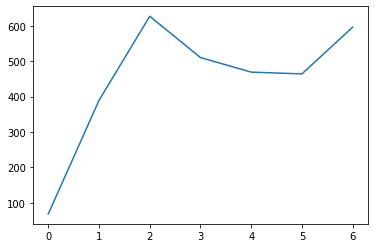

In [ ]:
plt.plot(mean_test_prof)

In [ ]:
smt_results=[]
prof_results=[]

for year in range(2012,2019):
    func =partial(evaluate,year1=year,year2=year)

    max_bound = np.ones(4)
    min_bound = np.zeros(4)
    bounds = [(min_bound[i], max_bound[i]) for i in range(4)]

    res = differential_evolution(func,bounds=bounds,disp=True,workers=2,seed=43)
    smt_results.append(res.x*100)
    prof_results.append(res.fun*-1)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/_differentialevolution.py:494: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  " updating='deferred'", UserWarning)


differential_evolution step 1: f(x)= -128.385
differential_evolution step 2: f(x)= -128.385
differential_evolution step 3: f(x)= -129.4
differential_evolution step 4: f(x)= -129.4
differential_evolution step 5: f(x)= -129.4
differential_evolution step 6: f(x)= -129.4
differential_evolution step 7: f(x)= -134.567
differential_evolution step 8: f(x)= -134.694
differential_evolution step 9: f(x)= -137.769
differential_evolution step 10: f(x)= -142.198
differential_evolution step 11: f(x)= -142.198
differential_evolution step 12: f(x)= -147.569
differential_evolution step 13: f(x)= -147.569
differential_evolution step 14: f(x)= -147.569
differential_evolution step 15: f(x)= -147.569
differential_evolution step 16: f(x)= -147.569
differential_evolution step 17: f(x)= -147.569
differential_evolution step 18: f(x)= -148.093
differential_evolution step 19: f(x)= -148.093
differential_evolution step 20: f(x)= -148.093
differential_evolution step 21: f(x)= -148.093
differential_evolution step 22

/usr/local/lib/python3.7/dist-packages/scipy/optimize/_differentialevolution.py:494: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  " updating='deferred'", UserWarning)


differential_evolution step 1: f(x)= -384.492
differential_evolution step 2: f(x)= -384.492
differential_evolution step 3: f(x)= -384.492
differential_evolution step 4: f(x)= -384.492
differential_evolution step 5: f(x)= -395.061
differential_evolution step 6: f(x)= -398.395
differential_evolution step 7: f(x)= -403.965
differential_evolution step 8: f(x)= -403.965
differential_evolution step 9: f(x)= -409.206
differential_evolution step 10: f(x)= -409.206
differential_evolution step 11: f(x)= -409.206
differential_evolution step 12: f(x)= -409.206
differential_evolution step 13: f(x)= -409.206
differential_evolution step 14: f(x)= -409.206
differential_evolution step 15: f(x)= -409.206
differential_evolution step 16: f(x)= -409.206
differential_evolution step 17: f(x)= -409.206
differential_evolution step 18: f(x)= -409.206
differential_evolution step 19: f(x)= -409.206
differential_evolution step 20: f(x)= -409.206
differential_evolution step 21: f(x)= -409.206
differential_evolution

/usr/local/lib/python3.7/dist-packages/scipy/optimize/_differentialevolution.py:494: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  " updating='deferred'", UserWarning)


differential_evolution step 1: f(x)= -628.741
differential_evolution step 2: f(x)= -628.741
differential_evolution step 3: f(x)= -647.689
differential_evolution step 4: f(x)= -651.311
differential_evolution step 5: f(x)= -655.207
differential_evolution step 6: f(x)= -658.997
differential_evolution step 7: f(x)= -662.435
differential_evolution step 8: f(x)= -662.435
differential_evolution step 9: f(x)= -662.435
differential_evolution step 10: f(x)= -662.435
differential_evolution step 11: f(x)= -662.435
differential_evolution step 12: f(x)= -668.368
differential_evolution step 13: f(x)= -668.368
differential_evolution step 14: f(x)= -668.368
differential_evolution step 15: f(x)= -668.368
differential_evolution step 16: f(x)= -668.368
differential_evolution step 17: f(x)= -668.368
differential_evolution step 18: f(x)= -668.368
differential_evolution step 19: f(x)= -668.368


/usr/local/lib/python3.7/dist-packages/scipy/optimize/_differentialevolution.py:494: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  " updating='deferred'", UserWarning)


differential_evolution step 1: f(x)= -556.553
differential_evolution step 2: f(x)= -556.553
differential_evolution step 3: f(x)= -557.832
differential_evolution step 4: f(x)= -564.321
differential_evolution step 5: f(x)= -564.321
differential_evolution step 6: f(x)= -564.321
differential_evolution step 7: f(x)= -565.212
differential_evolution step 8: f(x)= -566.292
differential_evolution step 9: f(x)= -569.12
differential_evolution step 10: f(x)= -569.632
differential_evolution step 11: f(x)= -569.632
differential_evolution step 12: f(x)= -569.632
differential_evolution step 13: f(x)= -569.632
differential_evolution step 14: f(x)= -569.632
differential_evolution step 15: f(x)= -569.632
differential_evolution step 16: f(x)= -569.632
differential_evolution step 17: f(x)= -569.632


/usr/local/lib/python3.7/dist-packages/scipy/optimize/_differentialevolution.py:494: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  " updating='deferred'", UserWarning)


differential_evolution step 1: f(x)= -469.125
differential_evolution step 2: f(x)= -469.125
differential_evolution step 3: f(x)= -478.759
differential_evolution step 4: f(x)= -481.207
differential_evolution step 5: f(x)= -481.207
differential_evolution step 6: f(x)= -488.254
differential_evolution step 7: f(x)= -489.421
differential_evolution step 8: f(x)= -489.421
differential_evolution step 9: f(x)= -489.421
differential_evolution step 10: f(x)= -491.152
differential_evolution step 11: f(x)= -491.152
differential_evolution step 12: f(x)= -491.152
differential_evolution step 13: f(x)= -491.152
differential_evolution step 14: f(x)= -491.979
differential_evolution step 15: f(x)= -491.979
differential_evolution step 16: f(x)= -498.196
differential_evolution step 17: f(x)= -498.196
differential_evolution step 18: f(x)= -498.196
differential_evolution step 19: f(x)= -498.196
differential_evolution step 20: f(x)= -502.858
differential_evolution step 21: f(x)= -502.858
differential_evolution

/usr/local/lib/python3.7/dist-packages/scipy/optimize/_differentialevolution.py:494: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  " updating='deferred'", UserWarning)


differential_evolution step 1: f(x)= -472.241
differential_evolution step 2: f(x)= -472.673
differential_evolution step 3: f(x)= -472.673
differential_evolution step 4: f(x)= -474.851
differential_evolution step 5: f(x)= -477.492
differential_evolution step 6: f(x)= -482.04
differential_evolution step 7: f(x)= -482.04
differential_evolution step 8: f(x)= -482.04
differential_evolution step 9: f(x)= -482.733
differential_evolution step 10: f(x)= -492.858
differential_evolution step 11: f(x)= -492.858
differential_evolution step 12: f(x)= -498.419
differential_evolution step 13: f(x)= -498.419
differential_evolution step 14: f(x)= -498.419
differential_evolution step 15: f(x)= -498.462
differential_evolution step 16: f(x)= -498.462
differential_evolution step 17: f(x)= -498.462
differential_evolution step 18: f(x)= -498.462
differential_evolution step 19: f(x)= -498.462
differential_evolution step 20: f(x)= -498.462
differential_evolution step 21: f(x)= -498.462
differential_evolution st

/usr/local/lib/python3.7/dist-packages/scipy/optimize/_differentialevolution.py:494: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  " updating='deferred'", UserWarning)


differential_evolution step 1: f(x)= -606.437
differential_evolution step 2: f(x)= -606.437
differential_evolution step 3: f(x)= -606.437
differential_evolution step 4: f(x)= -606.544
differential_evolution step 5: f(x)= -606.544
differential_evolution step 6: f(x)= -606.544
differential_evolution step 7: f(x)= -606.718
differential_evolution step 8: f(x)= -606.718
differential_evolution step 9: f(x)= -606.718
differential_evolution step 10: f(x)= -606.718
differential_evolution step 11: f(x)= -606.718
differential_evolution step 12: f(x)= -606.718
differential_evolution step 13: f(x)= -606.718


In [ ]:
over_prof = np.array(prof_results)
over_df = pd.DataFrame(over_prof,columns=['mean_profit'])
over_df['year']= np.arange(1982,2019)
over_df['train_test'] = 'over'

In [ ]:
np.array(smt_results)

array([[37.35675152, 82.88553767, 32.52538225],
       [37.18192217, 69.94614147, 34.71149299],
       [50.25091294, 65.59120488, 39.01266175],
       [59.55524108, 65.10039033, 33.3610664 ],
       [25.9004121 , 61.07515693, 32.63634212],
       [15.48873416, 46.58882356, 39.51241203],
       [21.09061389, 70.73531824, 39.13174538],
       [58.81783934, 67.79572613, 34.38490148],
       [70.15777082, 68.79940762, 40.75593239],
       [16.25735656, 72.71399319, 33.80252906],
       [57.37232998, 16.49217922, 45.04726498],
       [47.79382143,  8.49095325, 42.50260176],
       [55.68535507, 62.71059372, 37.11775382],
       [37.93772216, 64.30785904, 35.35075431],
       [31.97681325, 24.28899821, 29.38607065],
       [21.37781295, 55.33771293, 34.11194175],
       [54.28739695, 63.74489431, 46.84520779],
       [46.38596122, 58.89682992, 30.38748273],
       [37.12467656, 74.60409337, 41.30314374],
       [58.80320024, 73.43344853, 34.71785885],
       [70.08135357, 73.70561403, 35.485

In [ ]:
over_df['smt1'] = np.array(smt_results)[:,0]
over_df['smt2'] = np.array(smt_results)[:,1]
over_df['smt3'] = np.array(smt_results)[:,2]

In [ ]:
full_df = pd.concat([mean_df,over_df])

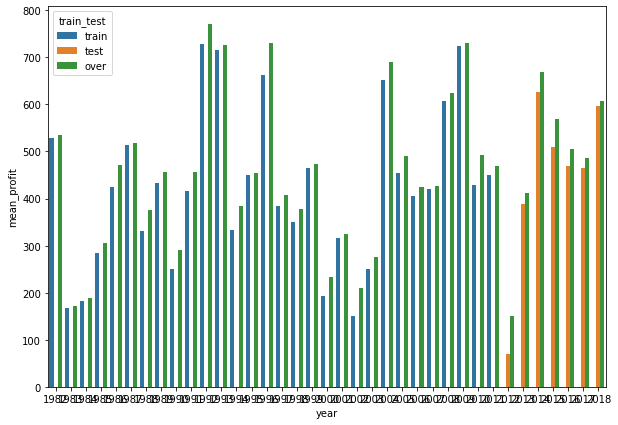

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(10,7))
sns.barplot(data=full_df,x='year',y='mean_profit',ax=ax,hue='train_test')

In [ ]:
full_df[full_df.year<2012].groupby('train_test').mean()

,mean_profit,year,smt1,smt2,smt3
train_test,,,,,
over,449.442166,1996.5,43.311185,60.785903,37.032887
train,422.139832,1996.5,47.595163,61.197686,36.150318


In [ ]:
full_df.to_csv('smt_paper2.csv',index=None)

In [ ]:
def evaluate_more(smt,year1,year2,eval=False,):

    global t,train_prof
    smt=smt.flatten()

    model = AquaCropModel(f'{year1}/05/01',f'{year2}/12/31',wdf,
            Soil=SoilClass('ClayLoam'),Crop=CropClass('Maize',PlantingDate='05/01'),
            InitWC=InitWCClass(wc_type='Pct',value=[70]),IrrMngt=IrrMngtClass(5))

    model.initialize()
    # model.weather[:,2]=0
    # model.weather[:,3]=3.5

    while not model.ClockStruct.ModelTermination:
        if model.InitCond.TAW>0:
            dep = model.InitCond.Depletion/model.InitCond.TAW
        else:
            dep=0

        # gs = int(model.InitCond.GrowthStage)-1
        gs = int(model.InitCond.DAP/9)
        if gs<0:
            depth=0
        else:
            if 1-dep< smt[gs]:
                depth = min(dep*model.InitCond.TAW,model.IrrMngt.MaxIrr)
            else:
                depth=0

        model.ParamStruct.IrrMngt.depth = depth
        model.step()


        if model.ClockStruct.ModelTermination:
            break

    fin = model.Outputs.Final
    if eval:
        return model.Outputs
    else:
        prof = (fin['Yield (tonne/ha)'].mean()*180 - fin['Seasonal irrigation (mm)'].mean()*1  -1728)
        # if t%50==0:
        #     train_prof.append(prof)
        # print(prof)
        return -prof

In [ ]:
int(155/9)

17

In [ ]:
evaluate_more(np.ones(20)*0.7,1982,2011)

-266.89460781392404

In [ ]:
func =partial(evaluate_more,year1=1982,year2=2011)

max_bound = np.ones(20)
min_bound = np.zeros(20)
bounds = [(min_bound[i], max_bound[i]) for i in range(20)]

res_new = differential_evolution(func,bounds=bounds,disp=True,workers=2,seed=43)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/_differentialevolution.py:494: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  " updating='deferred'", UserWarning)


differential_evolution step 1: f(x)= -378.319
differential_evolution step 2: f(x)= -381.016
differential_evolution step 3: f(x)= -395.76
differential_evolution step 4: f(x)= -395.76
differential_evolution step 5: f(x)= -395.76
differential_evolution step 6: f(x)= -396.27
differential_evolution step 7: f(x)= -396.27
differential_evolution step 8: f(x)= -401.667
differential_evolution step 9: f(x)= -401.667
differential_evolution step 10: f(x)= -401.667
differential_evolution step 11: f(x)= -401.667
differential_evolution step 12: f(x)= -401.667
differential_evolution step 13: f(x)= -403.571
differential_evolution step 14: f(x)= -403.571
differential_evolution step 15: f(x)= -403.571
differential_evolution step 16: f(x)= -409.626
differential_evolution step 17: f(x)= -409.626
differential_evolution step 18: f(x)= -409.626
differential_evolution step 19: f(x)= -409.626
differential_evolution step 20: f(x)= -409.705
differential_evolution step 21: f(x)= -409.705
differential_evolution step

In [ ]:
res = fmin(func,x0=np.ones(4)*0.6,)
evaluate(res,1989,2018)

Optimization terminated successfully.
         Current function value: 85.985543
         Iterations: 24
         Function evaluations: 75


-33.40440927095642

In [ ]:
res = fmin(func,x0=np.ones(4)*0.3,)
evaluate(res,1989,2018)

Optimization terminated successfully.
         Current function value: 6.063852
         Iterations: 37
         Function evaluations: 94


-86.35122542449426

In [ ]:
np.random.uniform(0,1,4)

array([0.70503484, 0.2688516 , 0.87511942, 0.49088893])

In [ ]:
# for k in range(20):
#     res = fmin(func,x0=np.random.uniform(0,1,4))
#     ptest=evaluate(res,1989,2018)
#     print('train',func(res),'test',ptest)

In [ ]:
func(res)

6.063852039380208

In [ ]:

# from pyswarms.single import GlobalBestPSO
# from functools import partial


# # Create bounds
# max_bound = np.ones(4)
# min_bound = np.zeros(4)
# bounds = (min_bound, max_bound)
# centre = np.ones(4)*0.5

# my_options = {'c1': 1, 'c2': 1, 'w':0.9}

# func =partial(evaluate,year1=1982,year2=1988)

# optimizer = GlobalBestPSO(n_particles=100, dimensions=4, options=my_options,center=centre) # Reuse our previous options
# res=optimizer.optimize(func, iters=10,verbose=0)

In [ ]:
# for k in range(20):

#     optimizer = GlobalBestPSO(n_particles=100, dimensions=4, options=my_options,center=centre) # Reuse our previous options
#     res=optimizer.optimize(func, iters=10,verbose=0)
#     print(res)